# 简介

本实验将利用Pytorch实现Word2Vec的CBOW+Negative Sampling模型，利用context word预测center word。

# 数据的载入

在本实验中将利用Penn Tree Bank语料库的文本训练数据`ptb.train.txt`进行词向量的训练。因为本实验是通过Colab进行的，所以需要首先从Colab中读取所需的数据：

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
path = "/content/drive/My Drive"
os.chdir(path)
!ls

 2238322.gdoc	   'Modern Family s01e01 Episode Script | SS.gdoc'
 2238322.pdf	   'Modern Family s01e01 Episode Script | SS.pdf'
'Colab Notebooks'   ptb.train.txt
 fractal.mp4	    WechatIMG7.jpeg


In [3]:
with open("ptb.train.txt", encoding="utf-8") as f:
    lines = f.readlines()
print(f"The number of lines is {len(lines)}.")

The number of lines is 42068.


我们可以看到该文本数据具有4万多行。

# 数据的读取

我们需要利用空格对每行文本进行分词，并统计词频，把词频低于5的低频词从词典中删去。

首先进行粗分词：

In [0]:
raw_datasets = [line.split() for line in lines]

结果：

In [5]:
for i in range(3):
    print(f"The first 6 words of the {i+1} line of raw datasets is \n{raw_datasets[i][:6]}.\n")

The first 6 words of the 1 line of raw datasets is 
['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett'].

The first 6 words of the 2 line of raw datasets is 
['pierre', '<unk>', 'N', 'years', 'old', 'will'].

The first 6 words of the 3 line of raw datasets is 
['mr.', '<unk>', 'is', 'chairman', 'of', '<unk>'].



由上面显示的结果，我们可以看到对于生僻词，文本中用`<unk>`表示，对于数字，文本用`N`表示。

接下来我们进行词频统计与删低频词：

In [0]:
from collections import Counter

counter = Counter([word for line in raw_datasets for word in line])
counter = dict(filter(lambda x: x[1] > 5, counter.items()))

进行完词频统计后，我们要建议word和index之间的转换索引：

In [0]:
idx_to_word = [word for word, _ in counter.items()]
word_to_idx = {word: idx for idx, word in enumerate(idx_to_word)}

结果：

In [8]:
index = word_to_idx['car']
print(f"The index of word 'car' is {word_to_idx['car']}.")
print(f"The word of index {index} is {idx_to_word[index]}.")

The index of word 'car' is 3786.
The word of index 3786 is car.


 然后我们可以通过词典来更新我们的文本数据集：

In [0]:
datasets = [[word_to_idx[word] for word in line if word in word_to_idx] for line in raw_datasets]
num_words = sum([len(line) for line in datasets])

结果：

In [10]:
datasets[2]

[14, 1, 15, 16, 17, 1, 18, 7, 19, 20, 21]

#二次采样

我们要进行二次采样，在文本数据集中，一些高频词往往没有低频词来得重要，譬如`'the'`，我们这时可以根据词频，以一定的概率丢到部分的词，来减少高频词的词频，同时时低频词的词频变化不大，对应的丢弃概率计算公式为：
$$
P(w_i)=\max\left(1-\sqrt{\frac{t}{f(w_i)}},0\right),
$$
其中$t=10^{-4}$。

In [0]:
import random
import math

def throw(idx):
    return random.uniform(0, 1) < (1 - math.sqrt(1e-4 / counter[idx_to_word[idx]] * num_words))

subsampling = [[idx for idx in line if not throw(idx)] for line in datasets]
new_num_words = sum([len(line) for line in subsampling])

In [12]:
print(f"Before subsamping, the number of words in the dataset is {num_words}.")
print(f"After subsamping, the number of words in the new dataset is {new_num_words}.")

Before subsamping, the number of words in the dataset is 885720.
After subsamping, the number of words in the new dataset is 374298.


这时我们要更新词频统计Counter：

In [0]:
counter = Counter([idx for line in subsampling for idx in line])

# 提取context word和center word

每次在整数1和`max_window_size`中随机选取一个整数作为背景窗口的大小。

In [0]:
def get_center_context(data, max_window_size=5):
    all_centers = []
    all_contexts = []
    for line in data:
        if len(line) < 2:
            continue
        all_centers += [[word] for word in line]
        for index in range(len(line)):
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, index-window_size), min(len(line), index+window_size+1)))
            indices.remove(index)
            all_contexts.append([line[idx] for idx in indices])
    return all_centers, all_contexts


我们可以用一些toy data去测试一下这个函数的有效性：

In [15]:
toy_data = [list(range(8)), [8, 9, 10]]
all_centers, all_contexts = get_center_context(toy_data, 2)
for center, context in zip(all_centers, all_contexts):
    print(f"Center: {center} -> Context: {context}")

Center: [0] -> Context: [1, 2]
Center: [1] -> Context: [0, 2, 3]
Center: [2] -> Context: [0, 1, 3, 4]
Center: [3] -> Context: [1, 2, 4, 5]
Center: [4] -> Context: [3, 5]
Center: [5] -> Context: [3, 4, 6, 7]
Center: [6] -> Context: [5, 7]
Center: [7] -> Context: [5, 6]
Center: [8] -> Context: [9]
Center: [9] -> Context: [8, 10]
Center: [10] -> Context: [8, 9]


由上我们可以得到该函数的有效性，我们现在要用该函数去提取对应的context words和center words：

In [0]:
all_centers, all_contexts = get_center_context(subsampling, 5)

# 负采样

因为我们的模型是CBOW模型，则要求对center word进行负采样，对每个center word采样$K=4$个noise word：

In [0]:
def get_negatives(all_centers, K, sampling_weights):
    population = list(range(len(sampling_weights)))
    all_negatives = []
    neg_candidate = []
    i = 0
    for word in all_centers:
        negatives = []
        while len(negatives) < K:
            if i == len(neg_candidate):
                neg_candidate = random.choices(population, sampling_weights, k=int(1e5))
                i = 0
            if neg_candidate[i] != word[0]:
                negatives.append(neg_candidate[i])
            i += 1
        all_negatives.append(negatives)
    return all_negatives

sampling_weights = [counter[idx] ** 0.75 for idx in counter]
all_negatives = get_negatives(all_centers, 4, sampling_weights)

#  数据读取

这时候我们需要利用Pytorch的DataLoader去读取我们的`all_centers`，`all_contexts`和，`all_negatives`：

In [0]:
import torch
import torch.nn as nn

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives
    
    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index], self.negatives[index])
    
    def __len__(self):
        return len(self.centers)

 在CBOW模型中，我们要把center word和negatives word链接在一起，与SkipGram不一样，每一个pair的长度都是一样的，不用补长，同时我们需要一个label向量，标记出哪个是正例，哪个是负例。

In [0]:
def batchify(data):
    contexts = []
    center_negative = []
    labels = []
    masks = []
    max_len = max([len(context) for _, context, _ in data])
    for center, context, negative in data:
        center_negative += [center + negative]
        labels += [[1] * len(center) + [0] * len(negative)]
        contexts += [context + [len(idx_to_word)] * (max_len - len(context))]
        masks += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(contexts), torch.tensor(center_negative),
            torch.tensor(labels), torch.tensor(masks))

In [23]:
batch_size = 512
data = MyDataset(all_centers, all_contexts, all_negatives)
data_iter = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                        shuffle=True, collate_fn=batchify)
for batch in data_iter:
    for name, data in zip(['contexts', 'center_negative', 'labels', 'masks'], batch):
        print(name, 'shape:', data.shape)
    break

contexts shape: torch.Size([512, 10])
center_negative shape: torch.Size([512, 5])
labels shape: torch.Size([512, 5])
masks shape: torch.Size([512, 10])


# CBOW model

In [0]:
def CBOW(contexts, center_negative, masks, embed_v, embed_u):
    v = embed_v(contexts).sum(dim=1) /  masks.sum(dim=-1).view(-1, 1) # [batch_size, embed_size]
    u = embed_u(center_negative) # [batch_size, c_ne_seq, embed_size]
    pred = torch.bmm(v[:, None, :], u.permute(0, 2, 1)) # [batch_size, c_ne_seq]
    return pred

Loss function:

In [0]:
class SigmoidBinaryCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(SigmoidBinaryCrossEntropyLoss, self).__init__()
    
    def forward(self, inputs, targets):
        inputs = inputs.float()
        targets = targets.float()
        loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        return loss.mean(dim=1)

criterion = SigmoidBinaryCrossEntropyLoss()

In [36]:
pred = torch.tensor([[1.5, 0.3, -1, 2], [1.1, -0.6, 2.2, 0.4]]).float()
label = torch.tensor([[1, 0, 0, 0], [1, 0, 0, 0]]).float()
criterion(pred, label).mean()

tensor(0.9299)

# 初始化模型参数

In [0]:
embed_size = 100
net = nn.Sequential(
    nn.Embedding(len(idx_to_word) + 1, embed_size),
    nn.Embedding(len(idx_to_word), embed_size)
)
net[0].weight.data[-1] = 0

训练函数

In [0]:
import time

def train(net, lr, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"torch on {device}")
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss_list = []
    for epoch in range(num_epochs):
        start, loss_sum, n = time.time(), 0., 0
        for batch in data_iter:
            contexts, center_negative, labels, masks = [d.to(device) for d in batch]
            pred = CBOW(contexts, center_negative, masks, net[0], net[1])
            loss = criterion(pred.view(labels.shape), labels).mean()
            loss_sum += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            net[0].weight.data[-1] = 0
            n += 1
        if (epoch + 1) % 5 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss_sum/n:.3f}, Time: {time.time()-start:.2f}s")
        loss_list.append(loss_sum/n)
    return loss_list

In [87]:
loss_list = train(net, 0.01, 30)

torch on cuda
Epoch: 5/30, Loss: 0.165, Time: 3.73s
Epoch: 10/30, Loss: 0.042, Time: 3.43s
Epoch: 15/30, Loss: 0.012, Time: 3.82s
Epoch: 20/30, Loss: 0.008, Time: 3.97s
Epoch: 25/30, Loss: 0.004, Time: 3.59s
Epoch: 30/30, Loss: 0.006, Time: 3.65s


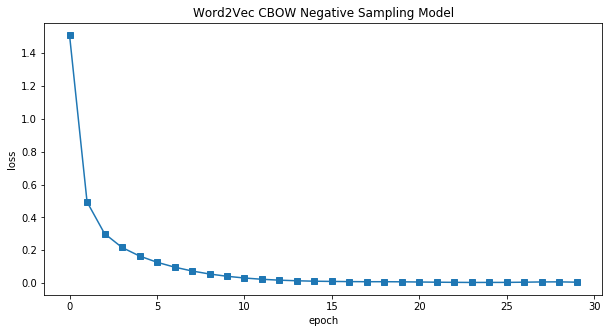

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec CBOW Negative Sampling Model')
plt.show()

#应用词嵌入模型

In [0]:
def get_similarity(word, k, embed):
    W = (embed[0].weight.data[:-1] + embed[1].weight.data) * 0.5
    x = W[word_to_idx[word]]
    cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
    _, topk = torch.topk(cos, k+1)
    for i in topk[1:]:
        print(f"cosine sim={cos[i]:.3f}: {idx_to_word[i]}.")

In [83]:
get_similarity("mother", 4, (net[0], net[1]))

cosine sim=0.426: husband.
cosine sim=0.401: her.
cosine sim=0.372: woman.
cosine sim=0.349: respectable.
